# Machine-Learning

- 各手法の学習やまとめ

---

## Useful Links

### RandomForestRegressor
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

### optuna
- https://qiita.com/studio_haneya/items/2dc3ba9d7cafa36ddffa
- https://qiita.com/koshian2/items/1c0f781d244a6046b83e
- https://qiita.com/hideki/items/c09242639fd74abe73a0
- https://tech.preferred.jp/ja/blog/hyperparameter-tuning-with-optuna-integration-lightgbm-tuner/
- https://qiita.com/tjmnmn/items/dee7f7e61328e6dd93f7

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [3]:
import xgboost as xgb
import lightgbm as lgb

In [4]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [5]:
import umap
import optuna

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

- TestData

In [10]:
#boston = load_boston()
#X, y = boston["data"], boston["target"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [9]:
df_boston = spark.table("sklearn.boston").toPandas()
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.04819,80.0,3.64,0.0,0.392,6.108,32.0,9.2203,1.0,315.0,16.4,392.89,6.57,21.9
1,0.03548,80.0,3.64,0.0,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,395.18,9.25,20.9
2,0.01538,90.0,3.75,0.0,0.394,7.454,34.2,6.3361,3.0,244.0,15.9,386.34,3.11,44.0
3,0.61154,20.0,3.97,0.0,0.647,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12,50.0
4,0.66351,20.0,3.97,0.0,0.647,7.333,100.0,1.8946,5.0,264.0,13.0,383.29,7.79,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [17]:
df_train = df_boston.sample(frac=0.8, random_state=15)
df_test = df_boston[~df_boston.index.isin(df_train.index)]

X_train = df_train.drop(columns=["target"]).values
y_train = df_train["target"].values

X_test = df_test.drop(columns=["target"]).values
y_test = df_test["target"].values

- `RandomForestRegressor`で`optuna`を試してみる
    - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    - https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [63]:
def objective_rfr(trial):
    # 大体GridSearchやRandomSearchをかけるようなイメージで範囲を指定していく
    
    #n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    n_estimators = trial.suggest_categorical("n_estimators", np.arange(100, 2100, step=100).tolist())
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt"])
    #max_depth = trial.suggest_categorical("max_depth", np.arange(10, 110, step=10))
    max_depth_ = np.arange(10, 110, step=10).tolist()
    max_depth_.append(None)
    max_depth = trial.suggest_categorical("max_depth", max_depth_)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
    )
    
    #X_opt, X_val, y_opt, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1123)
    #model.fit(X_opt, y_opt)
    
    #score = r2_score(y_pred=model.predict(X_val), y_true=y_val) * -1  # 最小化すべき値を返さないといけない
    score = cross_val_score(estimator=model,
                           X=X_train,
                           y=y_train,
                           cv=3,
                           scoring="r2",
                           n_jobs=-1).mean() * -1 # 最小化すべき値を返すため、-1をかける

    return score
    

In [64]:
# verbose
optuna.logging.set_verbosity("WARN")

In [65]:
%%time
study_rfr = optuna.create_study()
study_rfr.optimize(objective_rfr, n_trials=200, n_jobs=-1,)

print(study_rfr.best_params)
print(study_rfr.best_value)
print(study_rfr.best_trial)


df_study_rfr = study_rfr.trials_dataframe()
display(df_study_rfr)


model_opt = RandomForestRegressor(**study_rfr.best_params)
scores = cross_val_score(estimator=model_opt, X=X_train, y=y_train, scoring="r2", cv=5, n_jobs=-1)
print(f"validation score: {scores.mean(): .3f} +/- {scores.std()}")

model_opt.fit(X_train, y_train)
test_score = r2_score(
    y_true=y_test,
    y_pred=model_opt.predict(X_test)
)
print(f"test score: {test_score : .3f}")

{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
-0.873310681504171
FrozenTrial(number=199, value=-0.873310681504171, datetime_start=datetime.datetime(2020, 3, 15, 12, 39, 49, 338902), datetime_complete=datetime.datetime(2020, 3, 15, 12, 39, 56, 892548), params={'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000)), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt')), 'max_depth': CategoricalDistribution(choices=(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None)), 'min_samples_split': IntUniformDistribution(high=10, low=2), 'min_samples_leaf': IntUniformDistribution(high=4, low=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, user_

,number,value,datetime_start,datetime_complete,params_bootstrap,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,system_attrs__number,state
0,0,-0.833416,2020-03-15 12:12:13.852458,2020-03-15 12:12:49.081879,False,50.0,sqrt,4,5,1300,0,COMPLETE
1,1,-0.828646,2020-03-15 12:12:13.858323,2020-03-15 12:12:58.504467,True,30.0,auto,2,10,1100,1,COMPLETE
2,2,-0.869638,2020-03-15 12:12:13.860724,2020-03-15 12:12:53.724401,False,90.0,sqrt,1,3,1100,2,COMPLETE
3,3,-0.736596,2020-03-15 12:12:13.870810,2020-03-15 12:12:32.301190,False,60.0,auto,2,6,400,3,COMPLETE
4,4,-0.754035,2020-03-15 12:12:32.301732,2020-03-15 12:13:54.996399,False,NaN,auto,1,7,1900,4,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,-0.869165,2020-03-15 12:39:25.371292,2020-03-15 12:39:49.337965,False,50.0,sqrt,1,2,700,195,COMPLETE
196,196,-0.871242,2020-03-15 12:39:29.214395,2020-03-15 12:39:52.350818,False,60.0,sqrt,1,2,700,196,COMPLETE
197,197,-0.872013,2020-03-15 12:39:37.673237,2020-03-15 12:39:59.411643,False,50.0,sqrt,1,2,900,197,COMPLETE
198,198,-0.871892,2020-03-15 12:39:41.539076,2020-03-15 12:40:02.430970,False,90.0,sqrt,1,2,1500,198,COMPLETE


validation score:  0.871 +/- 0.04224717100764264
test score:  0.892
CPU times: user 34min 58s, sys: 7min 19s, total: 42min 18s
Wall time: 27min 52s


- 最後の試行がBestなので、より最適なところが存在すると思われる

,feature_importance
RM,0.263410
LSTAT,0.256464
NOX,0.083154
INDUS,0.079170
CRIM,0.064645
DIS,0.064368
PTRATIO,0.063652
AGE,0.032481
TAX,0.031771
B,0.023558


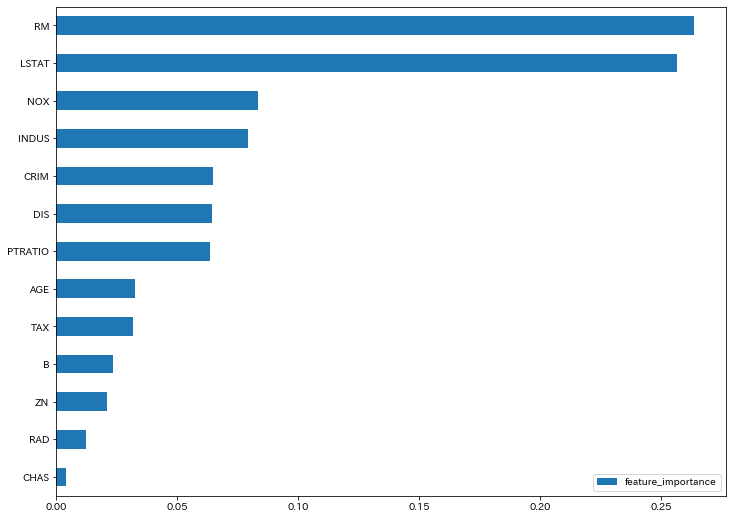

In [66]:
df_feature_importance = pd.DataFrame(model_opt.feature_importances_, index=df_boston.columns[:-1], columns=["feature_importance"]).sort_values("feature_importance", ascending=False)
display(df_feature_importance)
#pd.DataFrame(model_rfr_opt.feature_importances_, index=df_boston.columns[:-1]).plot.barh()
_, ax = plt.subplots(figsize=(12, 9))
df_feature_importance[::-1].plot.barh(ax=ax)
plt.show()

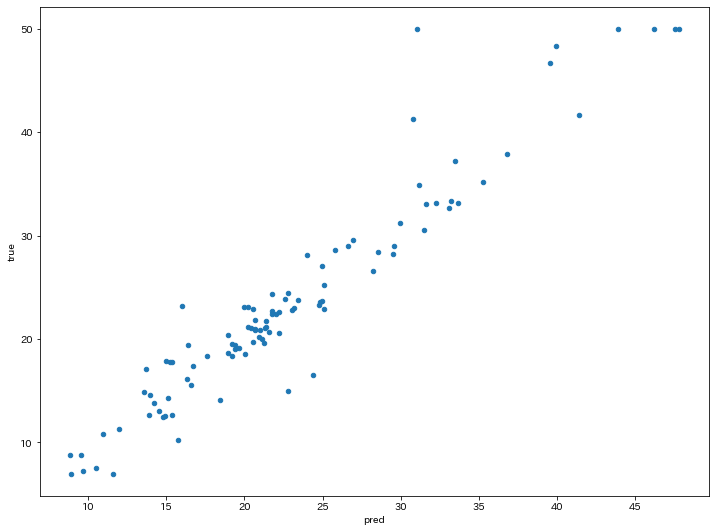

In [68]:
_, ax = plt.subplots(figsize=(12, 9))
pd.DataFrame({
    "pred": model_opt.predict(X_test),
    "true": y_test
}).plot.scatter("pred", "true", ax=ax)
plt.show()

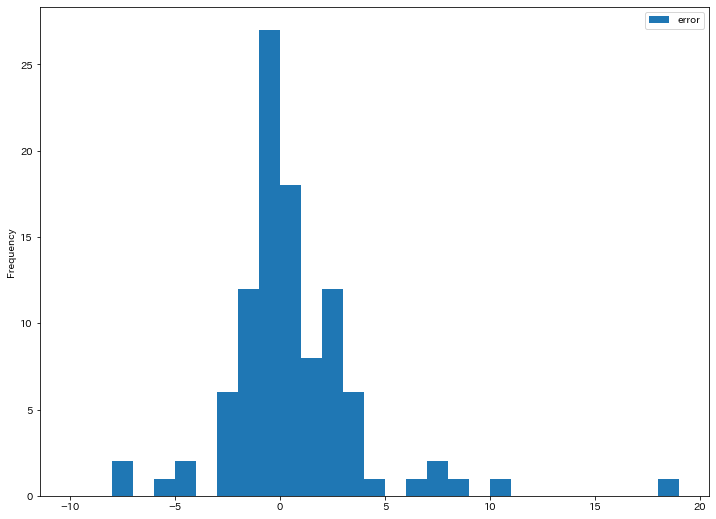

In [71]:
_, ax = plt.subplots(figsize=(12, 9))
pd.DataFrame({
    "error": y_test - model_opt.predict(X_test)
}).plot.hist(ax=ax, bins=np.arange(-10, 20))
plt.show()

In [50]:
def objective_rfr2(trial):
    # 大体GridSearchやRandomSearchをかけるようなイメージで範囲を指定していく
    
    #n_estimators = trial.suggest_discrete_uniform("n_estimators", 200, 2000, 200)
    n_estimators = trial.suggest_categorical("n_estimators", np.arange(200, 2200, step=200).tolist())
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt"])
    #max_depth = trial.suggest_categorical("max_depth", np.arange(10, 110, step=10))
    max_depth_ = np.arange(5, 35, step=5).tolist()
    max_depth_.append(None)
    max_depth = trial.suggest_categorical("max_depth", max_depth_)
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        n_jobs=-1,
    )
    
    #X_opt, X_val, y_opt, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1123)
    #model.fit(X_opt, y_opt)
    
    #score = r2_score(y_pred=model.predict(X_val), y_true=y_val)
    score = cross_val_score(estimator=model,
                            X=X_train, y=y_train,
                            cv=5,
                            #scoring="r2",
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                           ).mean() * -1

    return score

In [51]:
%%time
study_rfr2 = optuna.create_study()
study_rfr2.optimize(objective_rfr2, n_trials=10, n_jobs=-1,)

print(study_rfr2.best_params)
print(study_rfr2.best_value)
print(study_rfr2.best_trial)

df_study_rfr2 = study_rfr2.trials_dataframe()
display(df_study_rfr2)

{'n_estimators': 1400, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}
3.2231750201286915
FrozenTrial(number=6, value=3.2231750201286915, datetime_start=datetime.datetime(2020, 3, 15, 11, 31, 38, 964226), datetime_complete=datetime.datetime(2020, 3, 15, 11, 32, 43, 308283), params={'n_estimators': 1400, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}, distributions={'n_estimators': CategoricalDistribution(choices=(200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000)), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt')), 'max_depth': CategoricalDistribution(choices=(5, 10, 15, 20, 25, 30, None)), 'min_samples_split': CategoricalDistribution(choices=(2, 5, 10)), 'min_samples_leaf': IntUniformDistribution(high=4, low=1), 'bootstrap': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={'_number': 6}, intermediate_values={}, trial

,number,value,datetime_start,datetime_complete,params_bootstrap,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,system_attrs__number,state
0,0,3.362949,2020-03-15 11:30:33.436793,2020-03-15 11:31:20.716041,True,15.0,sqrt,1,5,600,0,COMPLETE
1,1,3.384910,2020-03-15 11:30:33.438384,2020-03-15 11:31:47.807221,False,25.0,sqrt,3,2,1200,1,COMPLETE
2,2,5.003123,2020-03-15 11:30:33.440829,2020-03-15 11:30:56.529851,False,15.0,auto,2,2,200,2,COMPLETE
3,3,3.360760,2020-03-15 11:30:33.445878,2020-03-15 11:31:38.963511,True,NaN,auto,1,5,800,3,COMPLETE
4,4,3.647109,2020-03-15 11:30:56.530405,2020-03-15 11:32:13.166863,True,30.0,auto,3,2,1200,4,COMPLETE
5,5,3.441463,2020-03-15 11:31:20.716774,2020-03-15 11:32:02.847493,True,25.0,sqrt,2,2,800,5,COMPLETE
6,6,3.223175,2020-03-15 11:31:38.964226,2020-03-15 11:32:43.308283,False,15.0,sqrt,2,2,1400,6,COMPLETE
7,7,3.794925,2020-03-15 11:31:47.807742,2020-03-15 11:32:40.295856,False,5.0,sqrt,4,10,1400,7,COMPLETE
8,8,3.724303,2020-03-15 11:32:02.848069,2020-03-15 11:32:41.397648,True,10.0,sqrt,3,10,800,8,COMPLETE
9,9,3.640713,2020-03-15 11:32:13.167794,2020-03-15 11:32:43.608952,True,10.0,sqrt,2,10,1000,9,COMPLETE


CPU times: user 2min 37s, sys: 28 s, total: 3min 5s
Wall time: 2min 10s


In [54]:
%%time
model_rfr_opt = RandomForestRegressor(**study_rfr2.best_params)
scores = cross_val_score(estimator=model_rfr_opt, X=X_train, y=y_train, scoring="r2", cv=5, n_jobs=-1)
print(f"validation score: {scores.mean(): .3f} +/- {scores.std()}")

model_rfr_opt.fit(X_train, y_train)
test_score = r2_score(
    y_true=y_test,
    y_pred=model_rfr_opt.predict(X_test)
)
print(f"test score: {test_score : .3f}")

validation score:  0.862 +/- 0.0396455851147949
test score:  0.876
CPU times: user 2.28 s, sys: 18.3 ms, total: 2.29 s
Wall time: 8.32 s


- 試行回数が10回とかなり少ないので、増やすことでより改善が見込めるはず
- 無調整でデフォルト設定値のRandomForestRegressorの場合は`0.85`くらいのスコアだったので、ある程度の改善が見られる
- 一方で、おおまかな傾向を見るだけだったらデフォルト設定値でもあまり困らないのかもしれない

,feature_importance
RM,0.280995
LSTAT,0.249516
NOX,0.089380
INDUS,0.082664
CRIM,0.063555
PTRATIO,0.061532
DIS,0.055194
TAX,0.032704
AGE,0.028504
B,0.020263


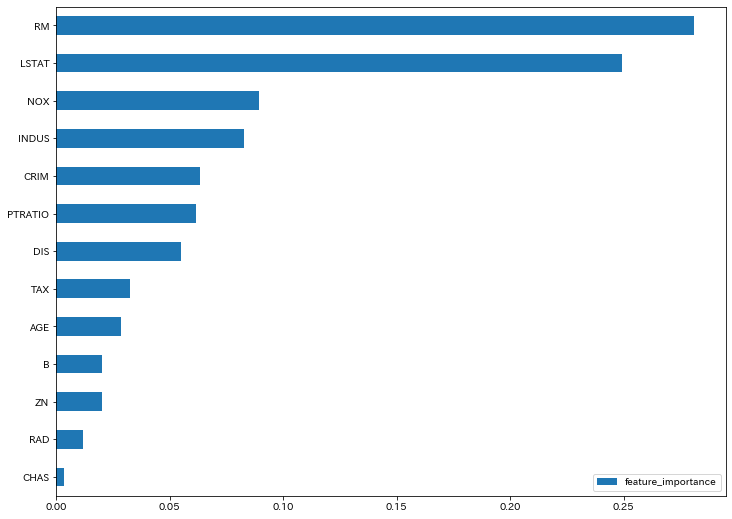

In [62]:
df_feature_importance = pd.DataFrame(model_rfr_opt.feature_importances_, index=df_boston.columns[:-1], columns=["feature_importance"]).sort_values("feature_importance", ascending=False)
display(df_feature_importance)
#pd.DataFrame(model_rfr_opt.feature_importances_, index=df_boston.columns[:-1]).plot.barh()
_, ax = plt.subplots(figsize=(12, 9))
df_feature_importance[::-1].plot.barh(ax=ax)
plt.show()

In [46]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [28]:
optuna.__version__

'1.1.0'

In [61]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu